In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import glob as gb
import cv2
import matplotlib.pylab as plt
plt.style.use('ggplot')

### Dataset source: https://www.kaggle.com/datasets/annielu21/house-rooms

In [2]:
import warnings

warnings.filterwarnings("ignore", message="All log messages before absl::InitializeLog() is called are written to STDERR")
warnings.filterwarnings("ignore", message="Fallback to op-by-op mode because memset node breaks graph update")

In [3]:
from sklearn.model_selection import train_test_split
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2024-06-21 04:56:09.131752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 04:56:09.131952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 04:56:09.304762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
set_random_seed(42)

In [6]:
# Path gambar
img_path = '/kaggle/input/house-rooms/room-dataset'

input_dir = 'images'
output_dir = 'output'

# Membuat folder output jika belum ada
os.makedirs(output_dir, exist_ok=True)

In [7]:
# Membuat Folder Kategori
categories = ['bathroom', 'bedroom', 'dining', 'gaming', 
              'kitchen','laundry','living', 'office',
             'terrace', 'yard']

for category in categories:
    category_dir = os.path.join(output_dir, category)
    os.makedirs(category_dir, exist_ok=True)

In [8]:
# Memindahkan file ke folder yang dipilih
for root, dirs, files in os.walk(img_path):
    for file in files:
        category = os.path.basename(root)
        if category in categories:
            source_file = os.path.join(root, file)
            destination_dir = os.path.join(output_dir, category)
            shutil.copy(source_file, destination_dir)

# Menampilkan jumlah file dalam setiap kategori
for category in categories:
    category_dir = os.path.join(output_dir, category)
    num_files = len(os.listdir(category_dir))
    print(f"Total {category} files: {num_files}")

Total bathroom files: 740
Total bedroom files: 1083
Total dining files: 1178
Total gaming files: 1511
Total kitchen files: 1208
Total laundry files: 1589
Total living files: 1164
Total office files: 1241
Total terrace files: 1210
Total yard files: 1398


In [9]:
# Buat folder train dan test
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data menjadi 70%train 30%test
for category in categories:
    category_dir = os.path.join(output_dir, category)
    images = os.listdir(category_dir)
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
    
    # Pindahkan gambar-gambar ke dalam folder train dan test
    for img in train_images:
        target_dir = os.path.join(train_dir, category)
        os.makedirs(target_dir, exist_ok=True)
        shutil.move(os.path.join(category_dir, img), os.path.join(target_dir, img))

    for img in test_images:
        target_dir = os.path.join(test_dir, category)
        os.makedirs(target_dir, exist_ok=True)
        shutil.move(os.path.join(category_dir, img), os.path.join(target_dir, img))

In [10]:
# Cetak jumlah gambar dalam folder train
print("\nJumlah Gambar dalam Folder Train:")
for category in categories:
    train_category_dir = os.path.join(train_dir, category)
    num_train_images = len(os.listdir(train_category_dir))
    print(f"{category}: {num_train_images} gambar")

# Cetak jumlah gambar dalam folder test
print("\nJumlah Gambar dalam Folder Test:")
for category in categories:
    test_category_dir = os.path.join(test_dir, category)
    num_test_images = len(os.listdir(test_category_dir))
    print(f"{category}: {num_test_images} gambar")


Jumlah Gambar dalam Folder Train:
bathroom: 518 gambar
bedroom: 758 gambar
dining: 824 gambar
gaming: 1057 gambar
kitchen: 845 gambar
laundry: 1112 gambar
living: 814 gambar
office: 868 gambar
terrace: 847 gambar
yard: 978 gambar

Jumlah Gambar dalam Folder Test:
bathroom: 222 gambar
bedroom: 325 gambar
dining: 354 gambar
gaming: 454 gambar
kitchen: 363 gambar
laundry: 477 gambar
living: 350 gambar
office: 373 gambar
terrace: 363 gambar
yard: 420 gambar


In [ ]:
from keras.preprocessing import image

def preprocess_with_clahe(img):
    # Konversi gambar ke array dengan tipe data uint8
    img_array = image.img_to_array(img, dtype='uint8')
    # Konversi gambar ke grayscale
    gray_img = convert_to_grayscale(img_array)
    # Terapkan CLAHE pada gambar grayscale
    img_clahe = apply_clahe(gray_img)
    # Lakukan preprocess_input VGG16
    img_preprocessed = preprocess_input(img_clahe)
    return img_preprocessed

Train Folder

Contoh Gambar untuk Kategori terrace:


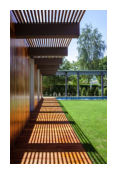


Contoh Gambar untuk Kategori gaming:


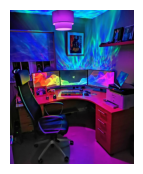


Contoh Gambar untuk Kategori bathroom:


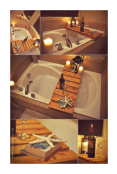


Contoh Gambar untuk Kategori bedroom:


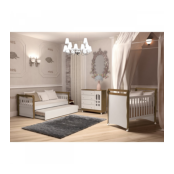


Contoh Gambar untuk Kategori laundry:


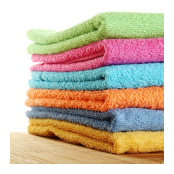


Contoh Gambar untuk Kategori yard:


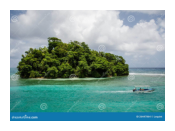


Contoh Gambar untuk Kategori office:


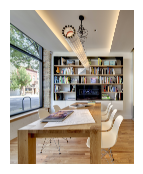


Contoh Gambar untuk Kategori living:


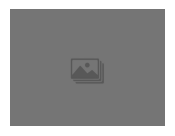


Contoh Gambar untuk Kategori dining:


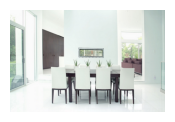


Contoh Gambar untuk Kategori kitchen:


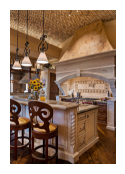


Test Folder

Contoh Gambar untuk Kategori terrace:


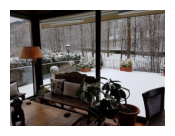


Contoh Gambar untuk Kategori gaming:


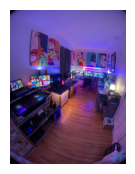


Contoh Gambar untuk Kategori bathroom:


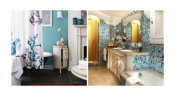


Contoh Gambar untuk Kategori bedroom:


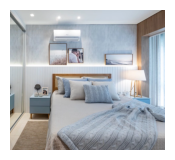


Contoh Gambar untuk Kategori laundry:


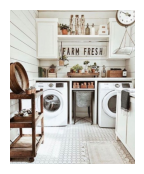


Contoh Gambar untuk Kategori yard:


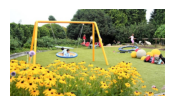


Contoh Gambar untuk Kategori office:


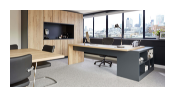


Contoh Gambar untuk Kategori living:


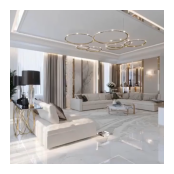


Contoh Gambar untuk Kategori dining:


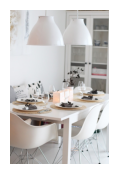


Contoh Gambar untuk Kategori kitchen:


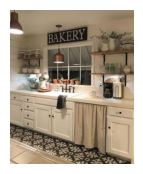

In [11]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_random_images(folder, num_images=1, figsize=(4, 4)):
    categories = os.listdir(folder)
    for category in categories:
        category_dir = os.path.join(folder, category)
        images = os.listdir(category_dir)
        random_images = random.sample(images, num_images)
        print(f"\nContoh Gambar untuk Kategori {category}:")
        for img_file in random_images:
            img_path = os.path.join(category_dir, img_file)
            img = mpimg.imread(img_path)
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.axis("off")
            plt.show()

print('Train Folder')
visualize_random_images(train_dir, figsize=(2, 2))
print('\nTest Folder')
visualize_random_images(test_dir, figsize=(2, 2)) 

In [ ]:
# np.random.seed(42)

# # Membuat objek ImageDataGenerator untuk pelatihan dengan preprocessing CLAHE
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     preprocessing_function=preprocess_with_clahe,
#     samplewise_center=True,
#     rotation_range=10,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False
# )

# traindata = train_datagen.flow_from_directory(
#     directory="./output/train", 
#     target_size=(224,224), 
#     color_mode="rgb", 
#     class_mode='categorical',
#     shuffle=False)

# # Membuat objek ImageDataGenerator untuk pengujian dengan preprocessing CLAHE
# test_datagen = ImageDataGenerator(
#     rescale=1./255,
#     preprocessing_function=preprocess_with_clahe,
#     samplewise_center=True
# )

# testdata = test_datagen.flow_from_directory(
#     directory="./output/test", 
#     target_size=(224,224), 
#     color_mode="rgb", 
#     class_mode='categorical',
#     shuffle=False)

In [13]:
# Membuat objek ImageDataGenerator untuk pelatihan dengan preprocessing CLAHE
train_datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True, 
    rotation_range=10, 
    zoom_range=0.1,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,  
    vertical_flip=False,
)

traindata = train_datagen.flow_from_directory(
    directory="./output/train", 
    target_size=(224,224), 
    color_mode="rgb", 
    class_mode='categorical',
    shuffle=False)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True
)

testdata = test_datagen.flow_from_directory(
    directory="./output/test", 
    target_size=(224,224), 
    color_mode="rgb", 
    class_mode='categorical',
    shuffle=False)

Found 8613 images belonging to 10 classes.
Found 3698 images belonging to 10 classes.


In [14]:
testdata.class_indices

{'bathroom': 0,
 'bedroom': 1,
 'dining': 2,
 'gaming': 3,
 'kitchen': 4,
 'laundry': 5,
 'living': 6,
 'office': 7,
 'terrace': 8,
 'yard': 9}

### MODELING

In [17]:
import efficientnet.keras as efn

base_model = efn.EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

base_model.summary()

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnet-b7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_dwconv      │ (None, 112, 112,  │        288 │ block1a_project_… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_bn          │ (None, 112, 112,  │        128 │ block1b_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_activation  │ (None, 112, 112,  │          0 │ block1b_bn[0][0]

 Total params: 64,097,680 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,720 (1.19 MB)

In [18]:
# freeze all layer
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Set memory growth for GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [20]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.regularizers import l2
import tensorflow as tf

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(base_model)
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(GlobalAveragePooling2D())

# # Adding additional Dense layers with Batch Normalization
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(len(categories), activation='softmax'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b7 (Functional)    │ (None, 7, 7, 2560)     │    64,097,680 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,680 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,680 (244.51 MB)

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD  # Import SGD optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


device_name = tf.test.gpu_device_name()

modelpath = './output/bestmodel.keras'

np.random.seed(42)

### train the model
with tf.device(device_name):
    
    optimizer = SGD()
    
    model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    
    # Early stopping for val_accuracy
    early_stopping_acc = EarlyStopping(monitor='val_accuracy', patience=10, 
                                       restore_best_weights=True, mode='max')

    # Early stopping for val_loss
    early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, 
                                        restore_best_weights=True, mode='min')

    
    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, 
                                  patience=8, min_lr=0.000005, verbose=1)

    
    # Callback ModelCheckpoint untuk menyimpan bobot terbaik
    checkpoint = ModelCheckpoint(
        modelpath,
        monitor='val_accuracy',
        save_best_only=True,  # Hanya menyimpan bobot terbaik
        mode='max',  # Mode untuk membandingkan nilai metrik (misalnya 'max' untuk akurasi)
        verbose=1  # Menampilkan pesan saat menyimpan
    )

    # Train the model
    history = model.fit(x=traindata, validation_data=testdata, epochs=200, 
                        batch_size=32, callbacks=[early_stopping_acc, early_stopping_loss,
                                                  checkpoint])

Epoch 1/200


AttributeError: Exception encountered when calling Activation.call().

[1mmodule 'keras.backend' has no attribute 'sigmoid'[0m

Arguments received by Activation.call():
  • inputs=tf.Tensor(shape=(None, 112, 112, 64), dtype=float32)

In [ ]:
#Test the model with the test set

model.evaluate(testdata)

In [ ]:
# Visualize the model

plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi label kelas menggunakan model terhadap data uji
predictions = model.predict(testdata)
predicted_classes = np.argmax(predictions, axis=1)

# Ambil label sebenarnya dari data uji
true_classes = testdata.labels

# Dapatkan nama kelas
class_labels = list(testdata.class_indices.keys())

# Buat classification matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification matrix
print("Classification Matrix:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Accuracy adalah rasio dari jumlah prediksi yang benar (true predictions) dibagi dengan jumlah total instance dalam dataset. 

Precision mengukur seberapa akurat model dalam memprediksi kelas positif. Ini dihitung sebagai rasio dari true positive (TP) dibagi oleh jumlah true positive dan false positive (FP). 

 Recall mengukur seberapa baik model dalam menemukan semua instance yang benar dari kelas yang diinginkan. Ini dihitung sebagai rasio dari true positive (TP) dibagi oleh jumlah true positive dan false negative (FN). 

F1-score adalah rata-rata harmonik dari precision dan recall. Ini memberikan keseimbangan antara precision dan recall.